# Comparación de distribuciones espaciales de dosis: gamma
------

En el flujo de trabajo de un Servicio de Radioterapia es común tener que comparar distribuciones espaciales de dosis, normalmente la distribución calculada frente a la distribución medida.

Estas comparaciones se realizan habitualmente en términos de la diferencia de dosis, la distancia al acuerdo o una métrica combinada de ambas que se denomina mapa gamma.

Los fundamentos de la diferencia de dosis y la distancia al acuerdo ya se presentaron mediante la [visualización de distribuciones planares de dosis](VisualizacionDistribucionesPlanaresDosis.ipynb). En este cuaderno presentaremos la manera de realizar la comparación mediante índices gamma.

Comenzamos dando algunas definiciones con más rigurosidad de lo que hicimos en el tutorial dedicado a la [visualización de distribuciones](VisualizacionDistribucionesPlanaresDosis.ipynb).

Dados dos mapas de dosis, $D_r$ dosis de referencia y $D_e$ dosis de evaluación, distribuidos en el espacio con coordenadas $\mathbf{r}_r$ y $\mathbf{r}_e$ la diferencia de dosis de dosis (*DD*) se define

\begin{equation}
    \Delta D = D_e(\mathbf{e}) - D_r(\mathbf{r})
\end{equation}

Fijémonos que para calcular la diferencia de dosis ambos mapas de dosis se refieren al mismo marco de referencia de coordenadas. 

Es habitual expresar la diferencia de dosis en términos relativos, normalmente en porcentaje del valor local

\begin{equation}
    \Delta D = \frac{D_e(\mathbf{e}) - D_r(\mathbf{r})}{D_r(\mathbf{r})}100
\end{equation}

o en porcentaje de un valor fijo de la dosis de referencia

\begin{equation}
    \Delta D = \frac{D_e(\mathbf{r}) - D_r(\mathbf{r})}{D_{\text{ref}}}100
\end{equation}

El valor $D_{\text{ref}}$ puede ser la dosis de prescripción, la dosis máxima en la distribución o cualquier otro valor que resulte relevante para el tratamiento.

La diferencia de dosis resulta especialmente informativa en regiones de bajo gradiente de dosis.

La distancia al acuerdo (*DTA*) es la distancia $d(\mathbf{r}_e, \mathbf{r}_r)$ que separa los puntos del espacio de evaluación $\mathbf{r}_e$ y de referencia $\mathbf{r}_r$ para un mismo valor de dosis. De forma más imprecisa podemos decir también que es la distancia que separa las curvas de isodosis entre ambas distribuciones. Es espcialmente informativa en regiones de alto gradiente de dosis.

Para criterios de aceptación $\delta D$ y $\delta d$,  sobre la diferencia de dosis y la distancia al acuerdo respectivamente, el índice $\gamma(\delta d, \delta D)$ es una métrica conjunta de la diferencia de dosis $\Delta D(\mathbf{r}_e, \mathbf{r}_r)$ y la distancia $d(\mathbf{r}_e, \mathbf{r}_r)$ definida como

\begin{equation}
\gamma(\mathbf{r}_r,\delta d, \delta D) = \text{min}\{ \sqrt{\frac{d^2(\mathbf{r}_e, \mathbf{r}_r)}{\delta d^2}+\frac{\Delta D^2(\mathbf{r}_e, \mathbf{r}_r)}{\delta D^2}} \} \forall \mathbf{r}_e
\end{equation}

Importaremos lo primero todos los módulos que nos harán falta en este tutorial, pero uno de ellos `pymedphys`, el módulo que permite el cálculo del índice gamma, no está por defecto instalado en **Colab**. Lo instalamos mediante el comando `pip` antes de invocar su importación.

In [ ]:
%pip install pymedphys

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
from pymedphys import gamma

Para poder realizar el análisis gamma de las distribuciones primero necesitamos las propias distribuciones.

Necesitaremos:

- Montar el disco gDrive
- Elegir el directorio de trabajo
- Descargar los archivos de las distribuciones

Para montar el disco importamos el módulo `drive` en **Colab** e invocamos la función de montado. Recordemos que tendremos que dar a **Colab** la autorización para acceder a nuestro *Drive*.

In [ ]:
# - Importar el módulo para acceder a Drive
from google.colab import drive
# - Montar el disco
drive.mount('/content/gdrive')

Cambiamos al directorio que mejor nos parezca. Siempre podemos utilizar la barra lateral de navegación por archivos para conocer la ruta de la carpeta que elijamos

In [ ]:
%cd ###Reemplazar con el directorio de trabajo###

Para este tutorial hemos colocado en **GitHub** los datos de las distribuciones. Los siguientes comandos los descargan a nuestra carpeta de trabajo

In [ ]:
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Colab/Plan.Sagital.dxf
!wget https://raw.githubusercontent.com/csarux/TutorialesFisicaRadioterapia/main/Colab/Plan.Sagital.Med.dxf

Leemos los archivos `dxf`con las distribuciones de dosis en sendos pandas DataFrames.

In [3]:
sdf = pd.read_csv('Plan.Sagital.dxf', header=47, sep='\t', names=np.arange(160))
smdf = pd.read_csv('Plan.Sagital.Med.dxf', header=47, sep='\t', names=np.arange(160))

Para calcular la comparación entre ambas distribuciones empleamos la función `gamma` del módulo `pymedphys`.

Los detalles sobre cómo invocarla los podemos consultar en la [documentación de la función gamma](https://docs.pymedphys.com/en/latest/users/ref/lib/gamma.html)

Definimos primero las coordenadas de los ejes en los que están definidos los mapas de dosis. 

En este caso las coordenadas de ambos mapas, referencia y evaluación, coinciden pero en general no tienen por qué. Puede ocurrir perfectamente que la resolución espacial del mapa de evaluación, normalmente tomada del planificador, sea distinta a la de referencia, que puede venir de diferentes detectores (película, array de cámaras de ionización, panel plano, etc)

In [12]:
xs, ys = np.arange(160), np.arange(160)

Calculamos el mapa gamma emplando un criterio global de 3%, 3 mm.

In [13]:
gamma_map = gamma((xs, ys), sdf.values, (xs, ys), smdf.values, 3, 3)

y lo representamos mediante `seaborn`. Definimos para ello un pandas DataFrame del mapa

In [15]:
gamma_map_df = pd.DataFrame(gamma_map)

Definimos también una función de conveniencia para representar los mapas sin tener que repetir mucho código

In [16]:
def mapplot(ddf, ax, cmap='jet', label='Dosis [Gy]', title=None):
    sns.heatmap(ddf, cmap=cmap, ax=ax, cbar_kws={'label': label})
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_title(title)
    return  

Representamos los mapas correspondientes a la distribución de referencia, de evaluación y el mapa gamma de comparación

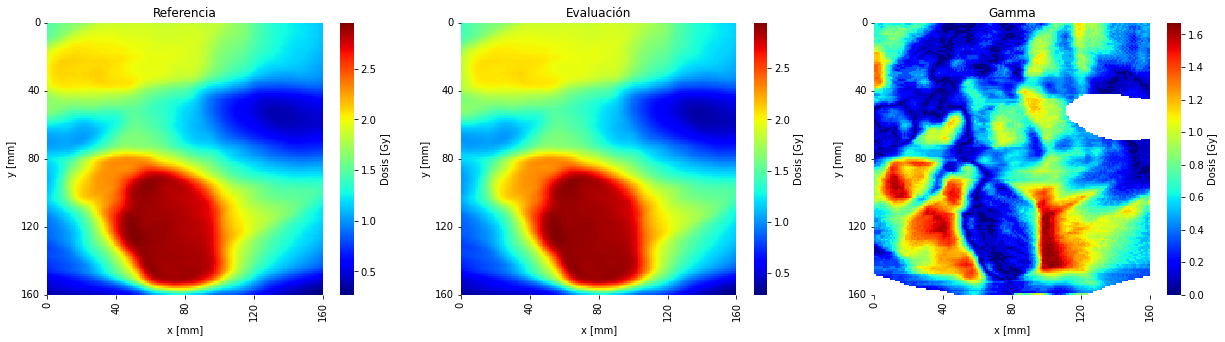

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(21, 5))
mapplot(sdf, ax1, title='Referencia')
mapplot(smdf, ax2, title='Evaluación')
mapplot(gamma_map_df, ax3, title='Gamma')

En el mapa gamma los pixeles de colores en la gamma caliente (amarillo, naranja, rojos) indican valores de gamma mayor de 1 que no pasarían nuestro criterio fijado de comparación de  3%, 3 mm.

Aparte de esta evaluación espacial también se realiza una evaluación cuantitativa de la distribución gamma mediante la realización de un histograma.

`matplotlib` cuenta con herramientas para calcular y representar histogramas de estructuras de datos que no contengan valores `nan` (_not a number_)

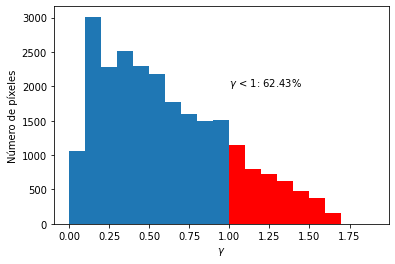

In [46]:
valid_gamma = gamma_map[~np.isnan(gamma_map)]
valid_gamma_gt1 = valid_gamma[valid_gamma > 1]
fig, ax = plt.subplots()
ax.hist(valid_gamma, bins=np.arange(0, 2, 0.1))
ax.hist(valid_gamma_gt1, bins=np.arange(1, 2, 0.1), color='r')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Número de píxeles')
ax.text(1, 2000, r'$\gamma$ < 1: {:.2f}%'.format((valid_gamma.sum() - valid_gamma_gt1.sum())/valid_gamma.sum() * 100))
plt.show()

En este caso el 62% de los puntos analizados no cumplen el criterio de paso.

Para objetivar el criterio de evaluación se suele fijar un porcentaje mínimo de puntos que deben superar el criterio para dar por aceptable la distribución evaluada, por ejemplo un 95%.

La definición de la gamma no impone ninguna restricción sobre el número de dimensiones de las distribuciones de dosis. Se puede realizar también la comparación mediante el índice gamma referida a distribuciones de dosis volumétricas (3D) o unidimensionales (1D).

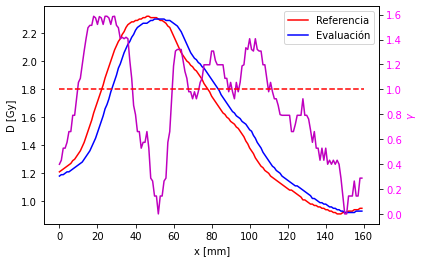

In [77]:
# Extraer un perfil de dosis de las dos distribuciones
prf = 80
rv = sdf.values[prf, :]  # Vector de dosis de referencia
ev = smdf.values[prf, :] # Vector de dosis de evaluación
# Definir las coordenadas de los perfiles de dosis
rx = np.arange(160)
ex = np.arange(160)

# Representar los perfiles
fig, ax = plt.subplots()

ax.plot(rx, rv, 'r-', label='Referencia')
ax.plot(ex, ev, 'b-', label='Evaluación')

ax.set_xlabel('x [mm]')
ax.set_ylabel('D [Gy]')
ax.legend()

# Calcular la comparción gamma
gamma_ax = gamma((rx), rv, (ex), ev, 3, 3)

# Representar en otro eje y compartiendo en mismo eje x
axg= ax.twinx()
axg.plot(rx, gamma_ax, 'm-')
axg.plot([0, 160], [1, 1], 'r--')
axg.set_ylabel(r'$\gamma$', color='magenta')
axg.tick_params(axis='y', labelcolor='magenta')

plt.show()

En esta gráfica es fácil introducir modificaciones para ver el efecto de los desplazamientos espaciales o de la normalización sobre el valor de $\gamma$